In [3]:
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import numpy as np
from pvlib.solarposition import get_solarposition
import pandas as pd
import json

# Brunger Hooper model
Brunger Hooper model is a model to calculate the radiation coming from any sky segment at any point in time. The model was published here: https://citeseerx.ist.psu.edu/document?repid=rep1&type=pdf&doi=93f59805f64fd372d7ce5e18addbeadcc846de6b


In [10]:
#constants for k=0.35, k_t=0.55, as explained in the paper
A0=.3006
A1=-.2172
A2=4.5443
A3=4.266
DIFFUSE_IRRADIANCE = 500
LATITUDE, LONGITUDE = 50.969166549784134, 10.291517731944065
# Divide the sky into PHI_SAMPLES * THETA_SAMPLES segments
PHI_SAMPLES = 20
THETA_SAMPLES = 20
# Number of random sun positions used for averaging 
# (Note that night times are filtered out, so the final average will be roughly 0.5* NUMBER_SUN_POSITIONS)
NUMBER_SUN_POSITIONS = int(1e3)


In [11]:
def sky_radiance(theta, phi, theta_sun, phi_sun, A0=A0, A1=A1, A2=A2, A3=A3, DIFFUSE_IRRADIANCE=DIFFUSE_IRRADIANCE):
    #equation 1 from paper
    psi = np.arccos(np.sin(theta)*np.sin(theta_sun)*np.cos(phi-phi_sun)+np.cos(theta)*np.cos(theta_sun))
    # equation 2 from paper
    I1 = (1+np.exp(-1*A3*np.pi/3))/(A3**2+4)
    I2 = 1-2*(1-np.exp(-A3*np.pi)/np.pi/A3/(1+np.exp(-1*A3*np.pi/2)))
    I3 = 2*theta_sun*np.sin(theta_sun) - 0.02*np.pi*np.sin(2*theta_sun)
    I=I1 * (np.pi - I2 * I3)

    nominator = A0 + A1*np.cos(theta) + A2*np.exp(-1*A3*psi)
    denominator = np.pi*(A0+2*A1/3) + 2*A2*I
    return DIFFUSE_IRRADIANCE*nominator/denominator

In [12]:
def generate_random_sunpositions(N, lat=LATITUDE, lon=LONGITUDE):
    def generate_random_timeseries(N):
        start = '2022-01-01'
        end = '2022-12-31'
        start_u = pd.to_datetime(start).value // 10**9
        end_u = pd.to_datetime(end).value // 10**9
        random_integers = np.random.randint(low=start_u, high=end_u, size=N)
        random_dates = pd.to_datetime(random_integers, unit='s')        
        return pd.Series(random_dates)


    time = generate_random_timeseries(N)
    positions = get_solarposition(time, latitude=lat, longitude=lon)
    positions_day = positions.loc[positions['apparent_elevation'] > 0, :]
    positions_day["apparent_zenith_rad"] = positions_day["apparent_zenith"]/90*np.pi/2
    positions_day["azimuth_rad"] = positions_day["azimuth"]/360*np.pi*2
    return positions_day["apparent_zenith_rad"].to_numpy(), positions_day["azimuth_rad"].to_numpy()

In [ ]:
phi = np.linspace(0, 2 * np.pi, PHI_SAMPLES)
theta = np.linspace(0, 0.5*np.pi, THETA_SAMPLES)
Phi, Theta = np.meshgrid(phi, theta)

Radiance = np.zeros_like(Phi)
sun_positions = generate_random_sunpositions(NUMBER_SUN_POSITIONS)

for i in range(len(sun_positions[0])):
    theta_sun, phi_sun = sun_positions[0][i], sun_positions[1][i]
    Radiance+= sky_radiance(theta=Theta, phi=Phi, theta_sun=theta_sun, phi_sun=phi_sun)
Radiance/=len(sun_positions[0])

json_str = json.dumps(np.round(Radiance, decimals=2).tolist())
with open("BrungerHooper.json", "w") as file:
    file.write(json_str)

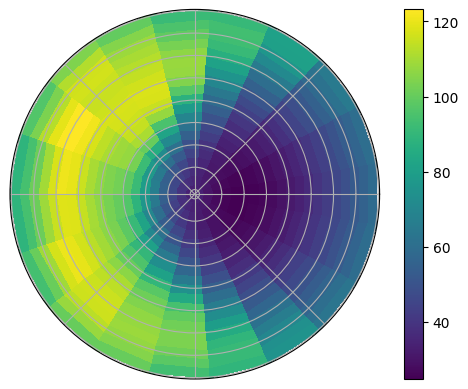

In [14]:
fig, ax = plt.subplots(subplot_kw={"projection": "polar"})
c = ax.pcolormesh(Phi, Theta, Radiance, shading='auto', norm=Normalize(vmin=Radiance.min(), vmax=Radiance.max()))
ax.set_yticklabels([])
ax.set_xticklabels([])
plt.colorbar(c, ax=ax, orientation='vertical')
plt.show()